# Gerardo de Miguel González

# Feature Selection Proof of Concept

## References

**::GMG::** Here I've aimed for an **embedded method** of *feature selection*. I've followed these references:

  - [Machine Learning Process](https://machinelearningmastery.com/an-introduction-to-feature-selection/) An Introduction to Feature Selection. By Jason Brownlee on October 6, 2014.
  - [Machine Learning Process](https://machinelearningmastery.com/feature-selection-machine-learning-python/) Feature Selection For Machine Learning in Python. By Jason Brownlee on May 20, 2016.
  - [Pythin for Machine Learning](https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/) Feature Selection in Python with Scikit-Learn. By Jason Brownlee on July 14, 2014.
  - [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/) Introduction to Feature Selection methods with an example (or how to select the right variables?). Saurav Kaushik, december 1, 2016.
  - [Scikit-learn](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel) Feature selection using `SelectFromModel`.

## Libraries

In [1]:
#::GMG::General tools for data handling
import pandas as pd
import numpy as np

In [2]:
#::GMG::seaborn: statistical data visualization for a heatmap of pandas.corr()
#::NOTE::There's a lot of fuss for 'heatmapping' with matplotlib only
# https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_annotated_heatmap.html
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

### load

**::GMG::** The dataset is [no longer available](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/) at [UCI](https://archive.ics.uci.edu/ml/index.php) but can be raw downloaded from the [dataset folder](https://github.com/jbrownlee/Datasets) in the [Github repository of Jason Brown Lee](https://github.com/jbrownlee) a known [data scientist blogger](https://machinelearningmastery.com/) whose references I'm using.

In [3]:
##::GMG::load raw dataset from Github (jbrownlee)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
#::NOTE::I put the same features names as jbrownlee's given them.
#        This is a short description of them from openml (https://www.openml.org/d/37)
#For Each Attribute: (all numeric-valued)
#
#    preg  - Number of times pregnant
#    plas  - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
#    pres  - Diastolic blood pressure (mm Hg)
#    skin  - Triceps skin fold thickness (mm)
#    test  - 2-Hour serum insulin (mu U/ml)
#    mass  - Body mass index (weight in kg/(height in m)^2)
#    pedi  - Diabetes pedigree function
#    age   - Age (years)
#    class - Class variable (0 or 1)
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
pima = pd.read_csv(url, names = names)

In [4]:
pima.tail()

,preg,plas,pres,skin,test,mass,pedi,age,class
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


**::GMG::** There are 8 different integer and real features and the categorical (binary) *Outcome* (i.e. classification) where 1 stands for having diabetes, and 0 denotes not havving diabetes. The dataset is known to have missing values. Specifically, there are missing observations for some columns that are marked as a zero value. A zero value will be invalid for for body mass index or blood pressure, for example.

In [5]:
print("Pima Indians Diabetes data set dimensions : {}".format(pima.shape))

Pima Indians Diabetes data set dimensions : (768, 9)


### exploratory data analysis

#### missing and  outliers

In [6]:
#::GMG::Let's check data types
# https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
preg     768 non-null int64
plas     768 non-null int64
pres     768 non-null int64
skin     768 non-null int64
test     768 non-null int64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [22]:
#::GMG::Let's check NAs and nulls
print('Nulls:\n {} \n\n NAs:\n {}'.format(pima.isnull().sum(), pima.isna().sum()))

Nulls:
 preg     0
plas     0
pres     0
skin     0
test     0
mass     0
pedi     0
age      0
class    0
dtype: int64 

 NAs:
 preg     0
plas     0
pres     0
skin     0
test     0
mass     0
pedi     0
age      0
class    0
dtype: int64


In [24]:
#::GMG::Statistics reveal some issues related to invalid values on some features, 
#       i.e. Glucose, BloodPressure, SkinThickness, Insulin and BMI 
#       which have ZEROS (min statistic) in their values!
#::NOTE::Do I need to standarize (scale) the features too?
pima.describe()

,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [31]:
#::GMG::Count the number of zeros/outliers in features that do not allow them
#       i.e plas, pres, skin, test, mass
pima[['plas','pres','skin','test', 'mass']].apply(lambda column: (column == 0).sum())

plas      5
pres     35
skin    227
test    374
mass     11
dtype: int64

In [33]:
#::GMG::Hard choice to make ... remove the rows where the “BloodPressure” (pres), 
#       “BMI” (mass) and “Glucose” (plas) are zero (small number of rows, low impact)
pima_mod = pima[(pima.pres != 0) & 
                (pima.mass != 0) & 
                (pima.plas != 0)
               ]

In [34]:
print(pima_mod.shape)

(724, 9)


**::GMG::** The problem with Insulin (`test`) and Skin Thickness (`skin`) is that they are a significant part of the dataset. They cannot be removed. I may use **an imputation method** to fill in the zeros, i.e. put *average/mean values*, but in this case putting a mean value to the blood pressure column *would send a wrong signal to the model*. I may also **avoid using the features** involved. Feature selection by filtering might come in handy and help with that. But the filter is going to use the *outliered* feature ... so I'm in doubt here!

#### feature correlations

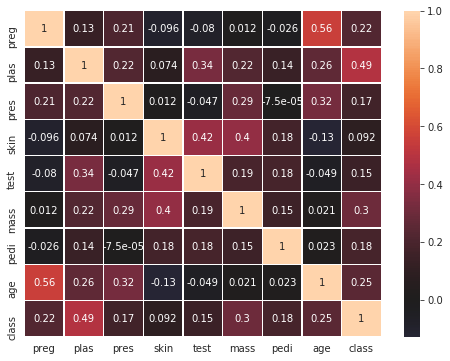

In [35]:
#::GMG::Not much insight from these corr() numbers
color = sns.color_palette()
sns.set_style('darkgrid')
plt.subplots(figsize=(8,6))
sns.heatmap(pima_mod.corr(), center=0, annot=True, linewidths=.3)

#### imbalance

In [27]:
#::GMG::Beware of the imbalance dataset ...
#       https://www.quora.com/What-is-an-imbalanced-dataset
#       https://www.datacamp.com/community/tutorials/diving-deep-imbalanced-data
#       https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
#       How do I check?
# https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8
data_final.groupby('Outcome').size()

Outcome
0    475
1    249
dtype: int64

Text(0, 0.5, 'Frequency %')

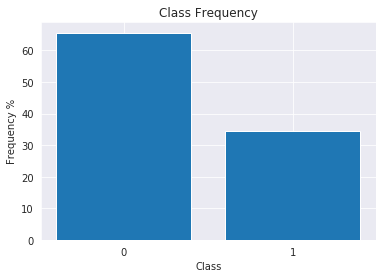

In [28]:
#::GMG::Say, 0 healthy, 1 diabetes
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.chararray.astype.html
# https://matplotlib.org/gallery/lines_bars_and_markers/categorical_variables.html
classes = data_final.Outcome.values
unique, counts = np.unique(classes, return_counts=True)
plt.bar(unique.astype(np.character),100*counts/classes.size)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency %')